# Проект модуля ML в бизнесе

### Постановка задачи

Проанализировать ВВП африканской страны Гана. Для этого нам предоставили показатели ВВП Ганы за 62 года. Цель проекта - исследовать временной ряд, изучить его свойства, построить модели и сделать выводы по результатам.

1. Импортируем библиотеки

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from arch import arch_model

2. Прочитаем данные

In [2]:
data = pd.read_csv("data/ghana_gdp.csv", parse_dates=["year"], index_col=["year"])
data.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


3. Визуализируем временной ряд

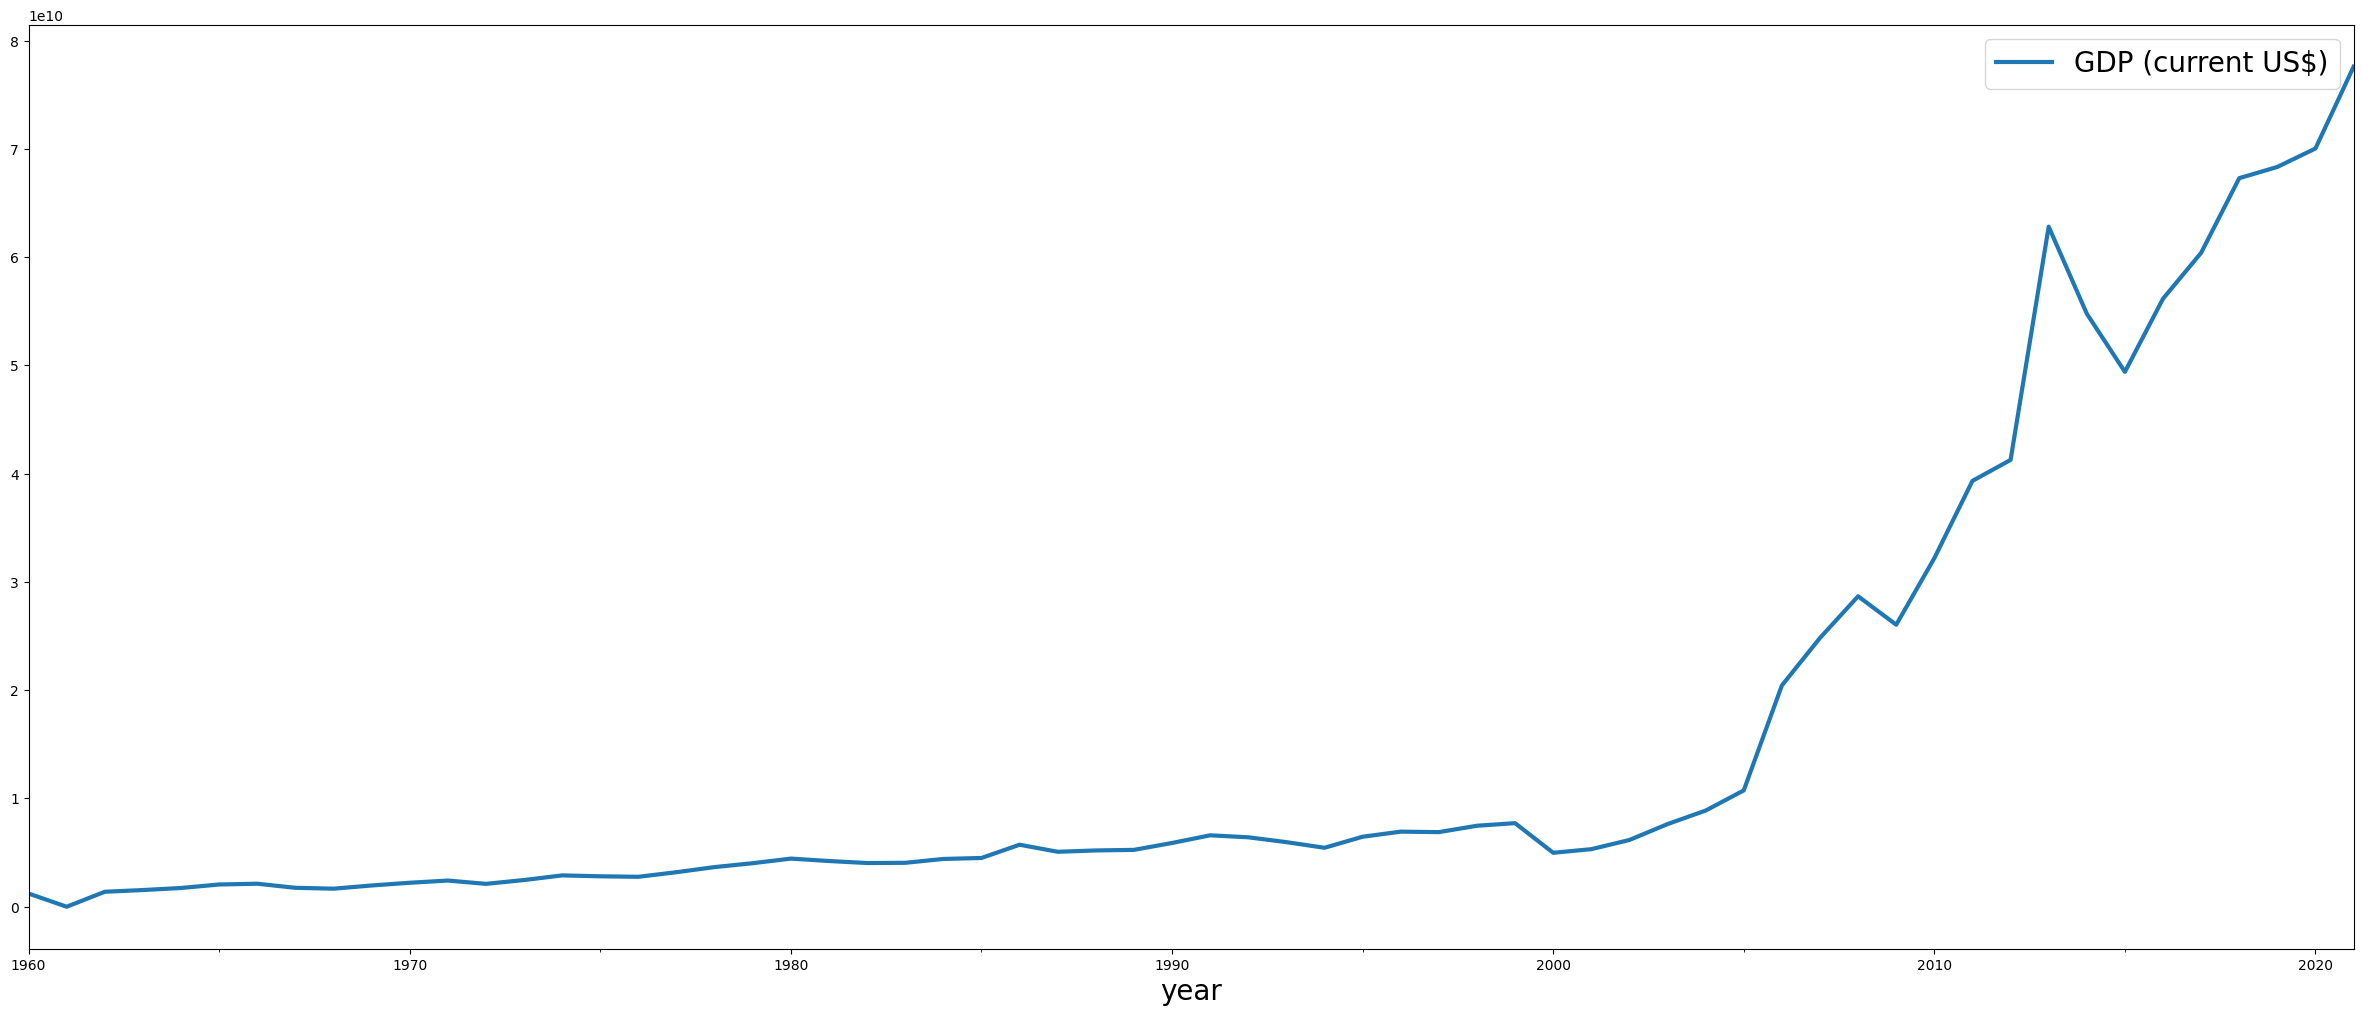

In [3]:
%matplotlib inline

plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

data.plot()
plt.show()

По графику ряда можно сделать первичный вывод о явном наличии тренда. Сезонность визуально не определяется на данном графике. Проведем декомпозицию ряда

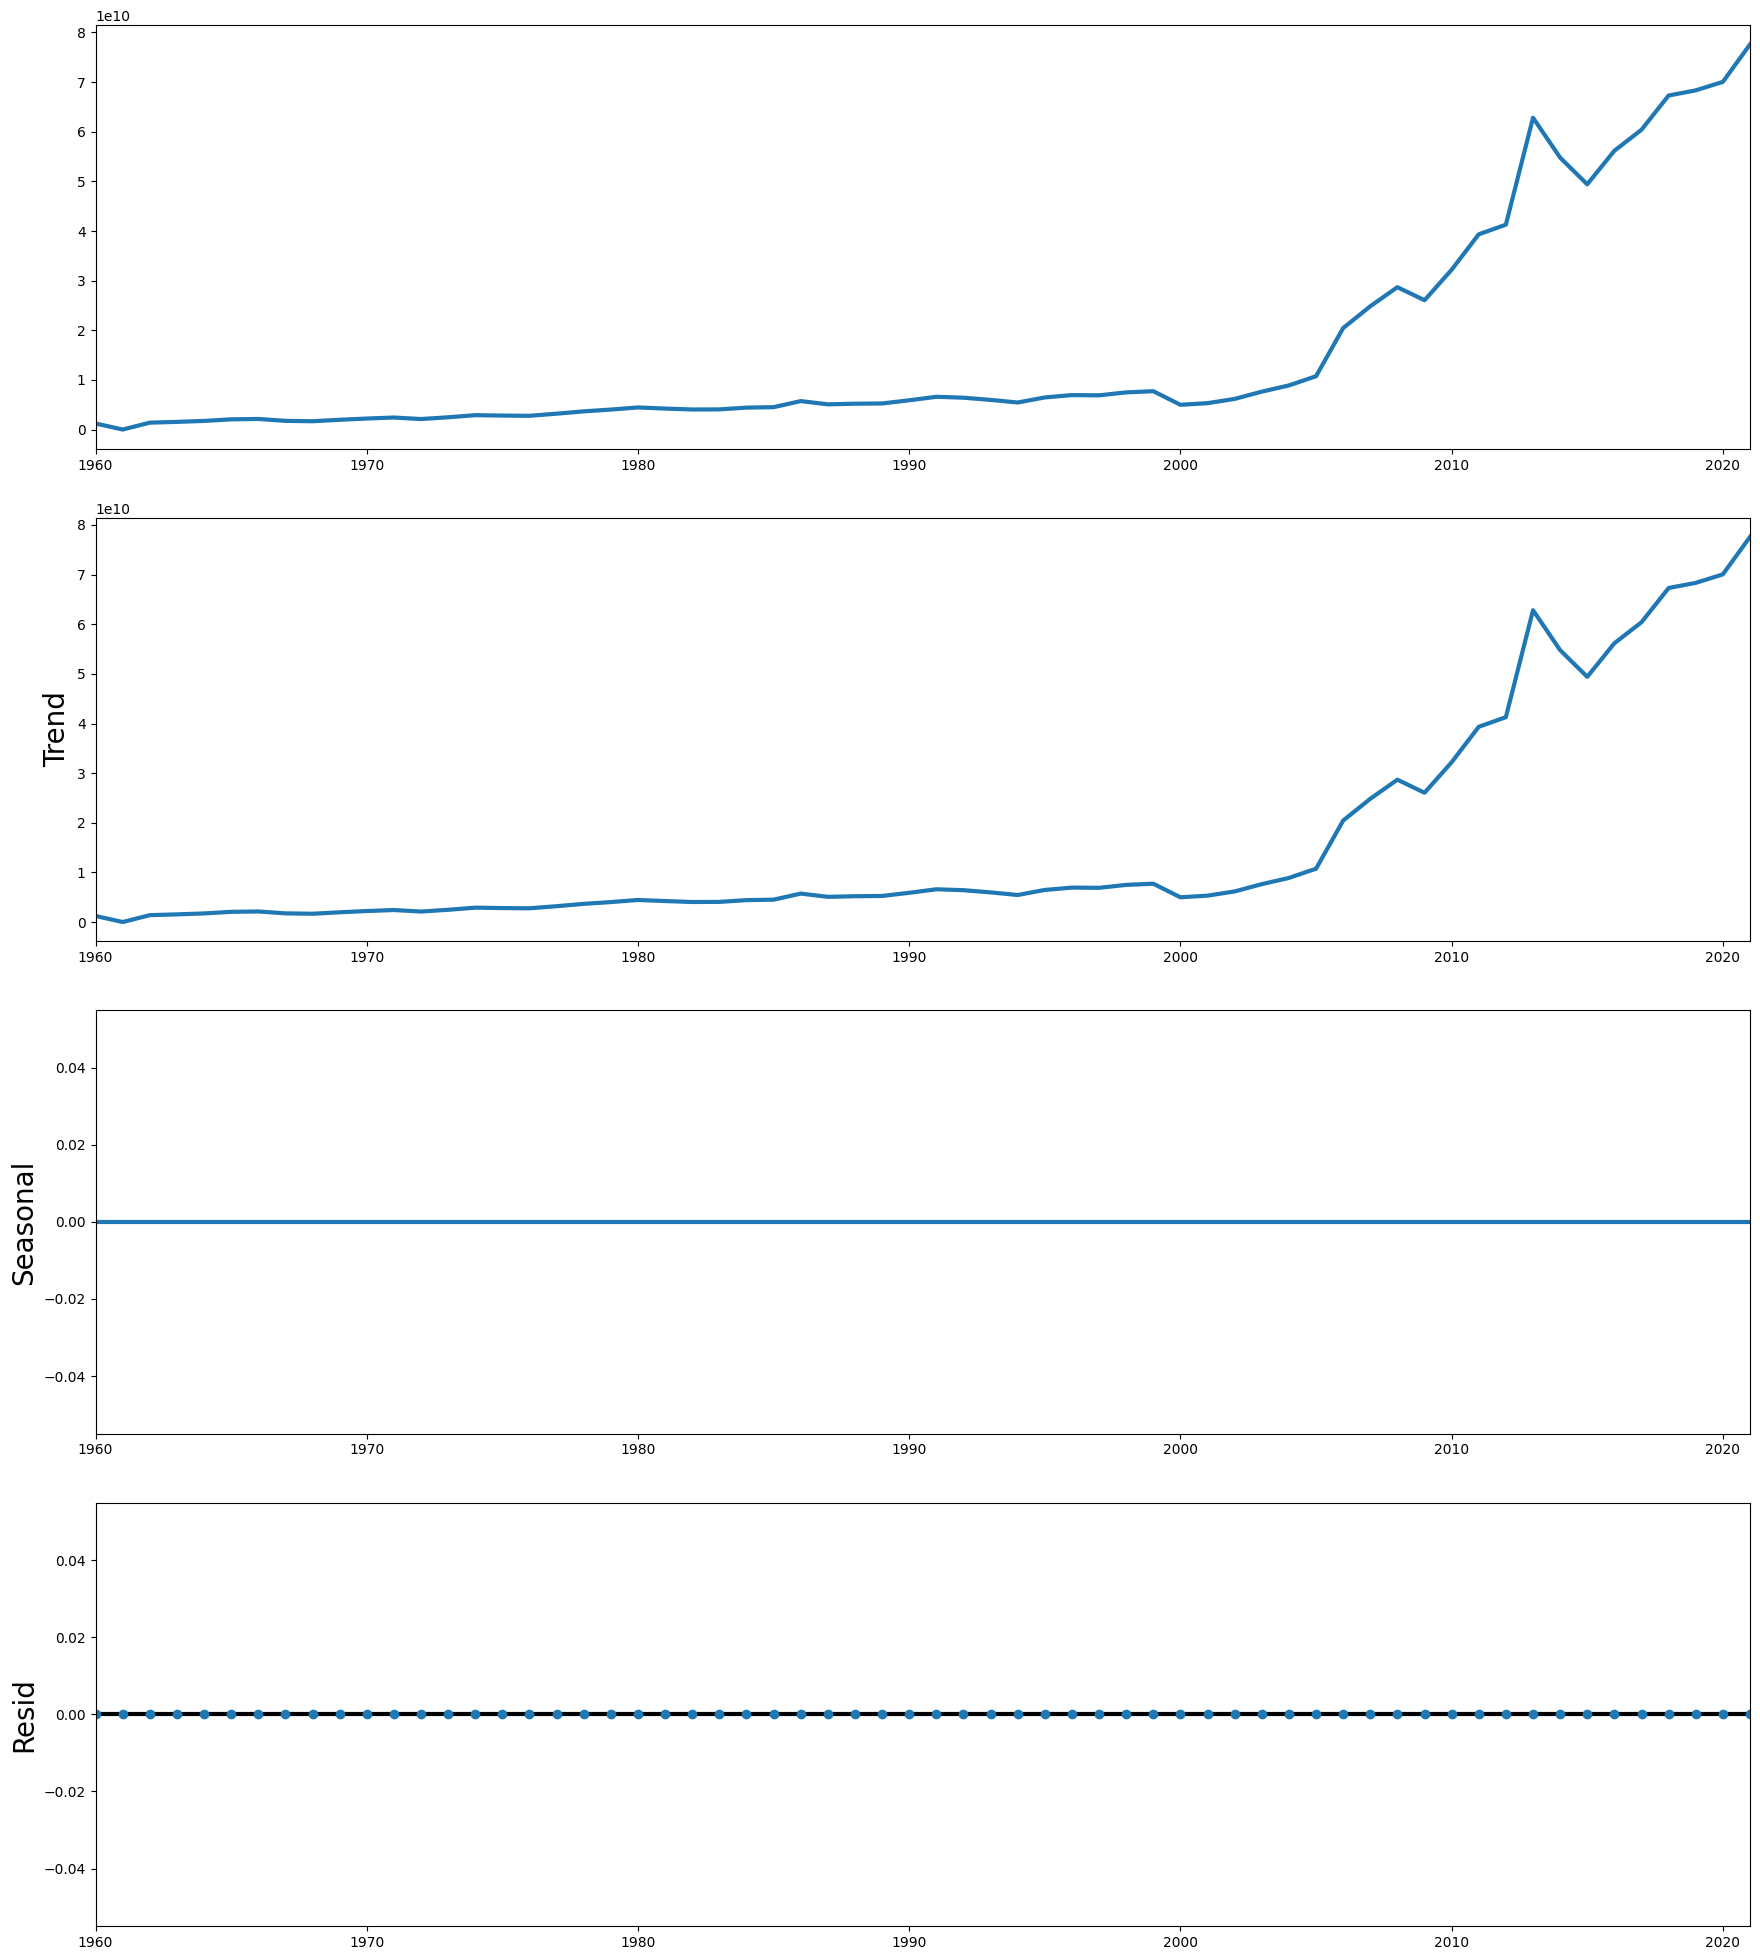

In [4]:
plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(data)
result.plot()
plt.show()

Здесь видно, что сезонность отсутствует

4. Разделим данные на тренировочные и тестовые (последние три года)

In [5]:
data.tail()

,GDP (current US$)
year,
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10
2020-01-01,7.004320e+10
2021-01-01,7.759428e+10


In [6]:
train_df = data.loc[:"2018-01-01"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

5. Построим график скользящего среднего

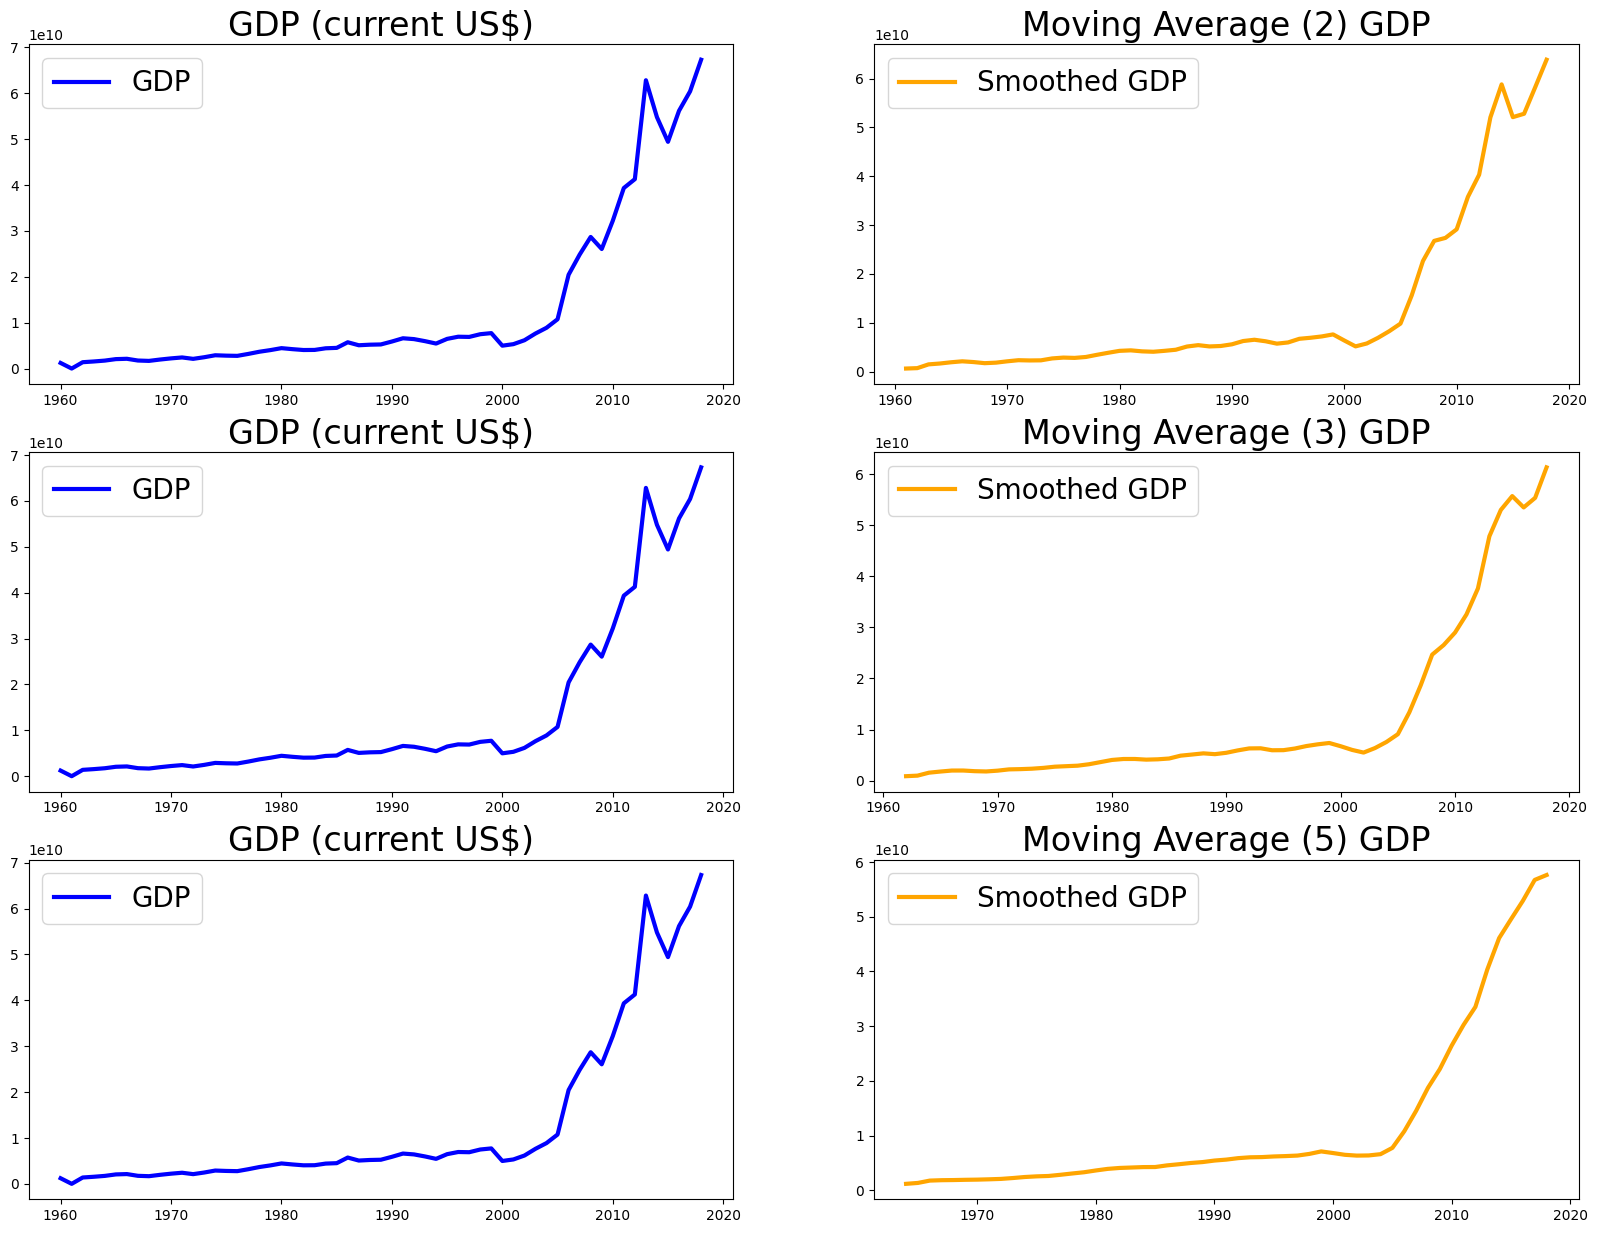

In [7]:
plt.rcParams["figure.figsize"] = 20, 15

fig, ax = plt.subplots(3, 2)

# Окно 2 года
ax[0, 0].plot(train_df, color="blue", label="GDP")
ax[0, 0].set_title("GDP (current US$)", size=24)
ax[0, 0].legend()

ax[0, 1].plot(
    train_df.rolling(window=2).mean(),
    color="orange",
    label="Smoothed GDP",
)

ax[0, 1].set_title("Moving Average (2) GDP", size=24)
ax[0, 1].legend()

# Окно 3 года
ax[1, 0].plot(train_df, color="blue", label="GDP")
ax[1, 0].set_title("GDP (current US$)", size=24)
ax[1, 0].legend()

ax[1, 1].plot(
    train_df.rolling(window=3).mean(),
    color="orange",
    label="Smoothed GDP",
)

ax[1, 1].set_title("Moving Average (3) GDP", size=24)
ax[1, 1].legend()

# Окно 5 лет
ax[2, 0].plot(train_df, color="blue", label="GDP")
ax[2, 0].set_title("GDP (current US$)", size=24)
ax[2, 0].legend()

ax[2, 1].plot(
    train_df.rolling(window=5).mean(),
    color="orange",
    label="Smoothed GDP",
)

ax[2, 1].set_title("Moving Average (5) GDP", size=24)
ax[2, 1].legend()

plt.show()

Видно, что большое окно в 5 лет приводит к потере информации в данных. В то же время сглаживания с окнами 2 или 3 года способны справиться с выбросами без существенных потерь.

6. Проверяем на стационарность

С помощью теста Дики-Фуллера

In [8]:
test1 = adfuller(train_df['GDP (current US$)'])
print("adf: ", test1[0])
print("p-value: ", test1[1])
print("Critical values: ", test1[4])
if test1[0] > test1[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  0.6529066974885349
p-value:  0.9888496277665572
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


Ряд нестационарен. Путем дифференцирования получим интегрированный ряд

In [9]:
train_df_diff = train_df.diff().dropna()

In [10]:
test2 = adfuller(train_df_diff)
print("adf: ", test2[0])
print("p-value: ", test2[1])
print("Critical values: ", test2[4])
if test2[0] > test2[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  -1.6702483038320777
p-value:  0.446502932971389
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
ряд нестационарен


Ряд по-прежнему нестационарен. Продолжаем дифференцирование

In [11]:
train_df_diff2 = train_df_diff.diff().dropna()

In [12]:
test3 = adfuller(train_df_diff2)
print("adf: ", test3[0])
print("p-value: ", test3[1])
print("Critical values: ", test3[4])
if test3[0] > test3[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  -2.6408690561284898
p-value:  0.08484116917837664
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд нестационарен


In [13]:
train_df_diff3 = train_df_diff2.diff().dropna()

In [14]:
test4 = adfuller(train_df_diff3)
print("adf: ", test4[0])
print("p-value: ", test4[1])
print("Critical values: ", test4[4])
if test4[0] > test4[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  -4.779623784828512
p-value:  5.9483276402254376e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд стационарен


Стационарный интегррованный ряд получен, параметр d будет равен 3, в качестве модели будем использовать ARIMA

7. Построим коррелограмму и график частичной автокорреляции для выбора параметров p и q

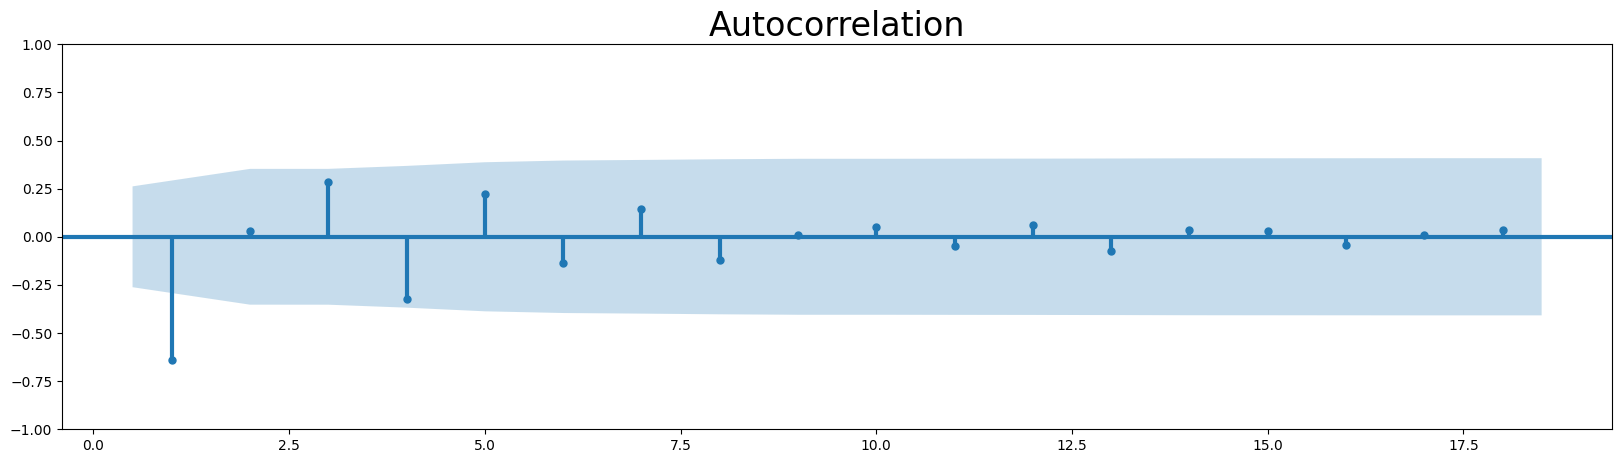

In [15]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df_diff3, zero=False)
plt.show()

По графику автокорреляции определяем параметр скользящего среднего q. В данном случае q=1

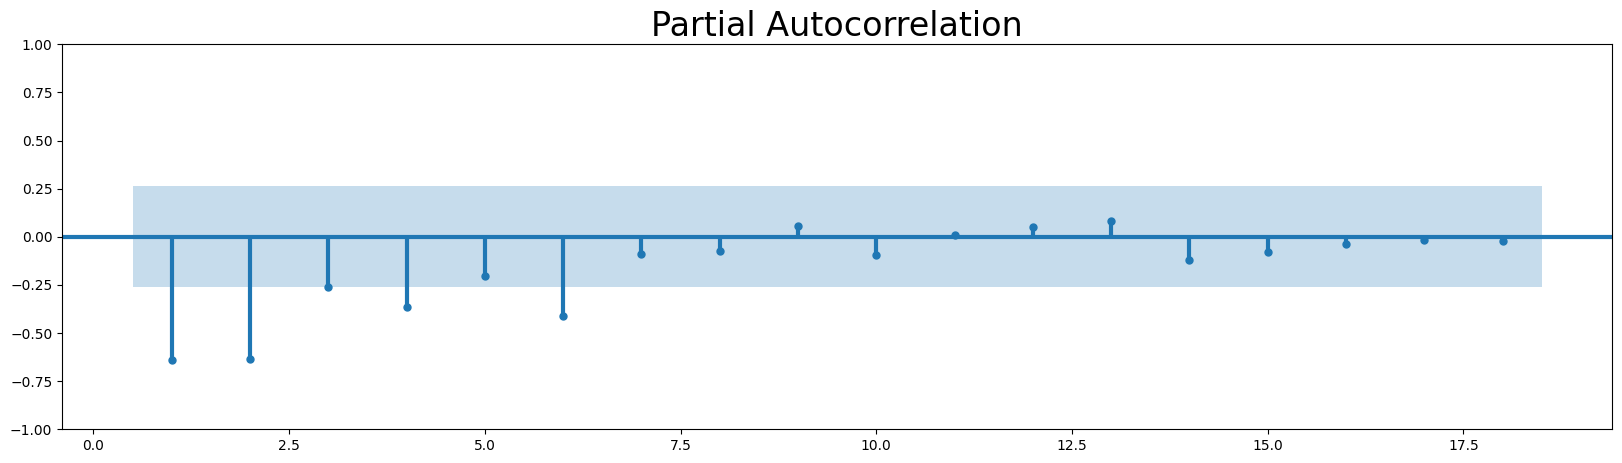

In [16]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df_diff3, method="ywm", zero=False)
plt.show()

По графику частичной автокорреляции определяем параметр p. В данном случае p=6

8. Строим модель ARIMA с данными параметрами

In [17]:
arima_model = ARIMA(train_df_diff3, order=(6, 3, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

c:\Users\Anna\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Anna\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Anna\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Anna\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   56
Model:                 ARIMA(6, 3, 1)   Log Likelihood               -1282.420
Date:                Wed, 16 Aug 2023   AIC                           2580.841
Time:                        14:49:39   BIC                           2596.603
Sample:                    01-01-1963   HQIC                          2586.902
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.2442      0.160    -14.018      0.000      -2.558      -1.930
ar.L2         -3.2336      0.309    -10.467      0.000      -3.839      -2.628
ar.L3         -3.2154      0.420     -7.658      0.000      -4.038      -2.392
ar.L4         -2.5772      0.542     -4.751      0.000      -3.640      -1.514
ar.L5         -1.5322      0.428     -3.580      0.000      -2.371      -0.693
ar.L6         -0.7086      0.195     -3.625      0.000      -1.092      -0.326
ma.L1         -0.9897      0.166     -5.945      0.000      -1.316      -0.663
sigma2      6.284e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   2.72   Jarque-Bera (JB):               337.74
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):              89.73   Skew:                            -1.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.91e+54. Standard errors may be unstable.
"""

Обращаем внимание на критерий Акаике (AIC), по нему будем сравнивать наши модели

9. Попробуем подобрать параметры с помощью pmdarima

In [18]:
smodel = pm.auto_arima(
    train_df_diff3,
    start_p=1,
    d=3,
    start_q=1,
    max_p=6,
    max_q=3,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2783.875, Time=0.02 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2738.092, Time=0.02 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2725.278, Time=0.05 sec
 ARIMA(0,3,2)(0,0,0)[0]             : AIC=2724.689, Time=0.06 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=2689.333, Time=0.09 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=2641.473, Time=0.42 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2633.335, Time=0.08 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2625.096, Time=0.29 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(4,3,1)(0,0,0)[0]             : AIC=2598.119, Time=0.37 sec
 ARIMA(4,3,0)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(5,3,1)(0,0,0)[0]             : AIC=2600.285, Time=0.31 sec
 ARIMA(4,3,2)(0,0,0)[0]             : AIC=2577.063, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   56
Model:               SARIMAX(4, 3, 2)   Log Likelihood               -1281.532
Date:                Wed, 16 Aug 2023   AIC                           2577.063
Time:                        14:49:44   BIC                           2590.855
Sample:                    01-01-1963   HQIC                          2582.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7655      0.244     -7.231      0.000      -2.244      -1.287
ar.L2         -2.0297      0.466     -4.356      0.000      -2.943      -1.117
ar.L3         -1.4879      0.577     -2.579      0.010      -2.619      -0.357
ar.L4         -0.7523      0.501     -1.503      0.133      -1.734       0.229
ma.L1         -1.9417      0.140    -13.874      0.000      -2.216      -1.667
ma.L2          0.9598      0.215      4.459      0.000       0.538       1.382
sigma2      6.422e+19   7.75e-21   8.28e+39      0.000    6.42e+19    6.42e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):               458.36
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):             119.80   Skew:                            -2.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.96e+57. Standard errors may be unstable.
"""

10. Построим модель с оптимальными параметрами

In [19]:
arima_model = ARIMA(train_df_diff3, order=(4, 3, 2))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

c:\Users\Anna\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Anna\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Anna\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   56
Model:                 ARIMA(4, 3, 2)   Log Likelihood               -1281.532
Date:                Wed, 16 Aug 2023   AIC                           2577.063
Time:                        14:49:45   BIC                           2590.855
Sample:                    01-01-1963   HQIC                          2582.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7655      0.244     -7.231      0.000      -2.244      -1.287
ar.L2         -2.0297      0.466     -4.356      0.000      -2.943      -1.117
ar.L3         -1.4879      0.577     -2.579      0.010      -2.619      -0.357
ar.L4         -0.7523      0.501     -1.503      0.133      -1.734       0.229
ma.L1         -1.9417      0.140    -13.874      0.000      -2.216      -1.667
ma.L2          0.9598      0.215      4.459      0.000       0.538       1.382
sigma2      6.422e+19   7.75e-21   8.28e+39      0.000    6.42e+19    6.42e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):               458.36
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):             119.80   Skew:                            -2.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.96e+57. Standard errors may be unstable.
"""

Таким образом мы добились, хоть и незначительного, но улучшения качества модели: AIC = 2577.063 (против предыдущего значения AIC = 2580.841)

11. Сделаем прогноз с помощью полученной модели

In [20]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["GPD"] = data["GDP (current US$)"]

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

In [21]:
pred_df

,model_preds,GPD,model_preds_lower,model_preds_upper
year,,,,
1960-01-01,NaN,1.217087e+09,NaN,NaN
1961-01-01,NaN,0.000000e+00,NaN,NaN
1962-01-01,NaN,1.382353e+09,NaN,NaN
1963-01-01,NaN,1.540616e+09,NaN,NaN
1964-01-01,NaN,1.731092e+09,NaN,NaN
...,...,...,...,...
2017-01-01,NaN,6.040638e+10,NaN,NaN
2018-01-01,NaN,6.729928e+10,NaN,NaN
2019-01-01,-7.607393e+09,6.833754e+10,-2.338339e+10,8.168604e+09


Визуализируем полученный результат

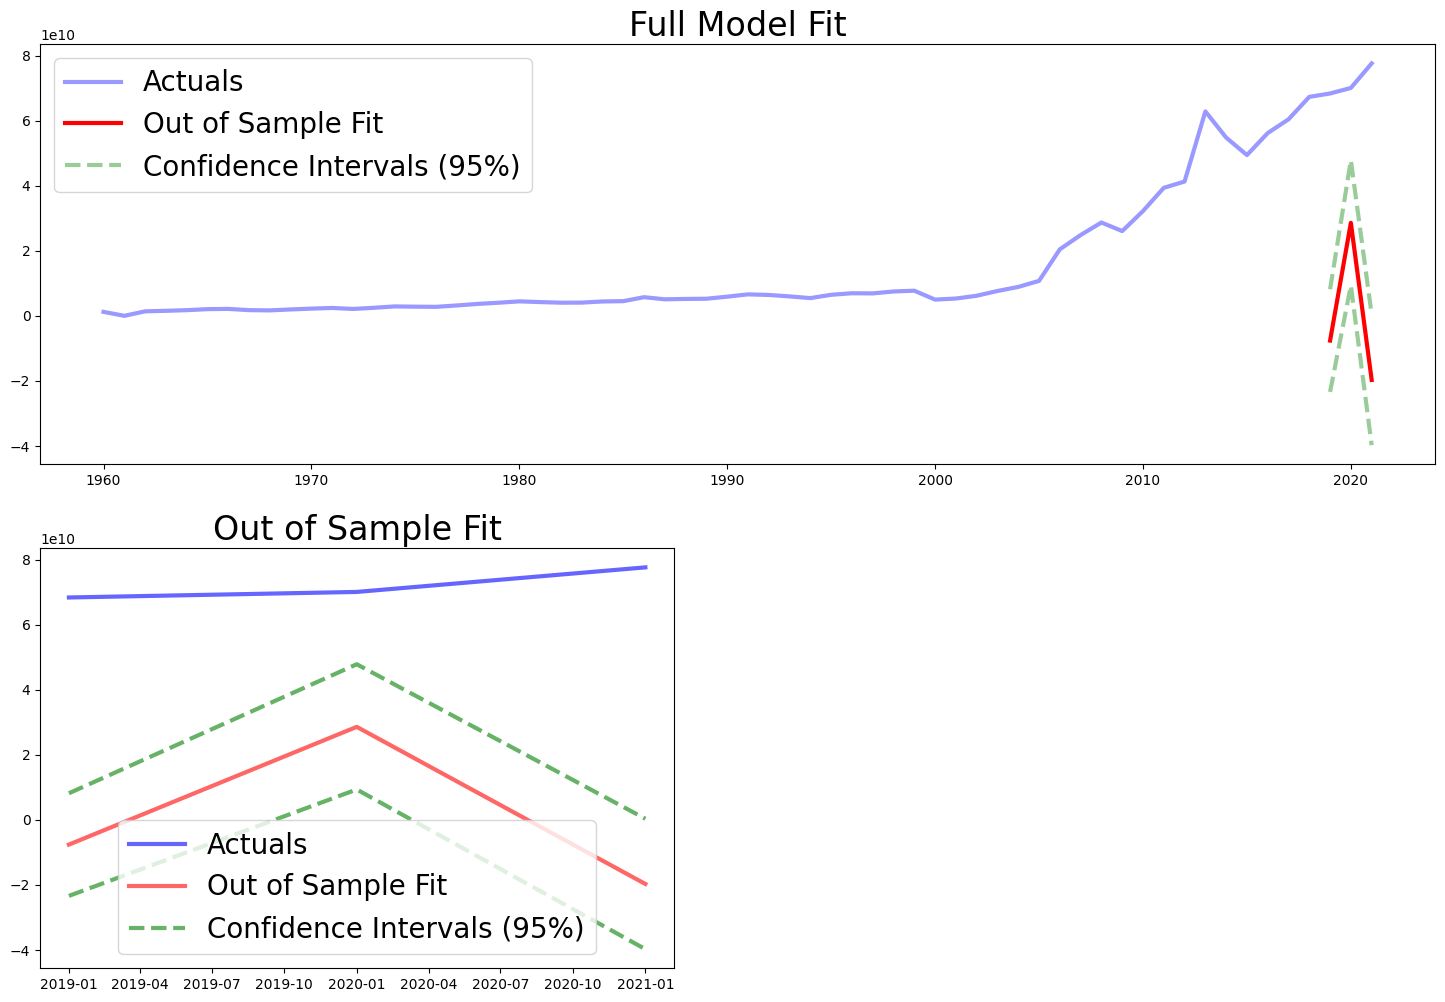

In [22]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GPD"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GPD"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

К сожалению, предсказания модели далеки от актуальных данных. Скорее всего необходим подбор более подходящих параметров и моделей.

#### Интерполяция

1. Проверим данные на наличие пропущенных дат

In [23]:
data['GDP (current US$)'] = data['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)
data.asfreq(freq='AS').isna().sum()

GDP (current US$)    1
dtype: int64

2. Проведем интерполяцию для заполнения пропущеных значений

In [24]:
data['GDP (current US$)'] = data['GDP (current US$)'].interpolate(method='linear')

3. Разделим данные на тренировочные и тестовые и проверим ряд на стационарность

In [25]:
train_df = data.loc[:"2018-01-01"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

In [26]:
test1 = adfuller(train_df['GDP (current US$)'])
print("adf: ", test1[0])
print("p-value: ", test1[1])
print("Critical values: ", test1[4])
if test1[0] > test1[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  0.8030073326980129
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


Ряд нестационарен, проводим дифференцирование

In [27]:
train_df_diff = train_df.diff().dropna()

In [28]:
test2 = adfuller(train_df_diff)
print("adf: ", test2[0])
print("p-value: ", test2[1])
print("Critical values: ", test2[4])
if test2[0] > test2[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  -1.8255652246435998
p-value:  0.36784515276563423
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
ряд нестационарен


In [29]:
train_df_diff2 = train_df_diff.diff().dropna()

In [30]:
test3 = adfuller(train_df_diff2)
print("adf: ", test3[0])
print("p-value: ", test3[1])
print("Critical values: ", test3[4])
if test3[0] > test3[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  -2.634634746007842
p-value:  0.0860481372219768
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд нестационарен


In [31]:
train_df_diff3 = train_df_diff2.diff().dropna()

In [32]:
test4 = adfuller(train_df_diff3)
print("adf: ", test4[0])
print("p-value: ", test4[1])
print("Critical values: ", test4[4])
if test4[0] > test4[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  -4.825603687304014
p-value:  4.857318076800112e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд стационарен


Мы добились стационарности ряда, параметр d=3

4. Произведем подбор параметров модели ARIMA

In [33]:
smodel = pm.auto_arima(
    train_df_diff3,
    start_p=1,
    d=3,
    start_q=1,
    max_p=8,
    max_q=5,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2783.863, Time=0.02 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2738.059, Time=0.02 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2725.301, Time=0.05 sec
 ARIMA(0,3,2)(0,0,0)[0]             : AIC=2725.654, Time=0.07 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=2690.039, Time=0.08 sec


 ARIMA(2,3,2)(0,0,0)[0]             : AIC=2641.358, Time=0.23 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2633.185, Time=0.13 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2624.942, Time=0.32 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(4,3,1)(0,0,0)[0]             : AIC=2597.909, Time=0.35 sec
 ARIMA(4,3,0)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(5,3,1)(0,0,0)[0]             : AIC=2600.125, Time=0.42 sec
 ARIMA(4,3,2)(0,0,0)[0]             : AIC=2576.837, Time=0.34 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=2610.519, Time=0.20 sec
 ARIMA(5,3,2)(0,0,0)[0]             : AIC=2578.743, Time=0.47 sec
 ARIMA(4,3,3)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(3,3,3)(0,0,0)[0]             : AIC=2591.490, Time=0.32 sec
 ARIMA(5,3,3)(0,0,0)[0]             : AIC=inf, Time=0.60 sec
 ARIMA(4,3,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec

Best model:  ARIMA(4,3,2)(0,0,0)[0]    

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   56
Model:               SARIMAX(4, 3, 2)   Log Likelihood               -1281.418
Date:                Wed, 16 Aug 2023   AIC                           2576.837
Time:                        14:49:51   BIC                           2590.629
Sample:                    01-01-1963   HQIC                          2582.141
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7656      0.225     -7.851      0.000      -2.206      -1.325
ar.L2         -2.0304      0.435     -4.668      0.000      -2.883      -1.178
ar.L3         -1.4895      0.553     -2.692      0.007      -2.574      -0.405
ar.L4         -0.7557      0.491     -1.538      0.124      -1.719       0.207
ma.L1         -1.9395      0.147    -13.205      0.000      -2.227      -1.652
ma.L2          0.9595      0.291      3.299      0.001       0.389       1.530
sigma2      6.418e+19   5.71e-21   1.12e+40      0.000    6.42e+19    6.42e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):               457.64
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):             424.88   Skew:                            -1.98
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.14e+55. Standard errors may be unstable.
"""

5. Строим модель с оптимальными параметрами

In [34]:
arima_model = ARIMA(train_df_diff3, order=(4, 3, 2))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

c:\Users\Anna\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Anna\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Anna\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   56
Model:                 ARIMA(4, 3, 2)   Log Likelihood               -1281.418
Date:                Wed, 16 Aug 2023   AIC                           2576.837
Time:                        14:49:51   BIC                           2590.629
Sample:                    01-01-1963   HQIC                          2582.141
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7656      0.225     -7.851      0.000      -2.206      -1.325
ar.L2         -2.0304      0.435     -4.668      0.000      -2.883      -1.178
ar.L3         -1.4895      0.553     -2.692      0.007      -2.574      -0.405
ar.L4         -0.7557      0.491     -1.538      0.124      -1.719       0.207
ma.L1         -1.9395      0.147    -13.205      0.000      -2.227      -1.652
ma.L2          0.9595      0.291      3.299      0.001       0.389       1.530
sigma2      6.418e+19   5.71e-21   1.12e+40      0.000    6.42e+19    6.42e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):               457.64
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):             424.88   Skew:                            -1.98
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.14e+55. Standard errors may be unstable.
"""

В связи с использованием интерполяции качество модели по критерию AIC при тех же параметрах улучшилось на десятые доли (2576,837 против 2577.063). Это мало, но и пропуск был всего один. Вероятно, этот метод способен существенно улучшить качество предсказания в условиях полноценной интерполяции.

#### Волатильность

1. Посчитаем волатильность

In [35]:
data["GDP_vol"] = (data['GDP (current US$)'] - data['GDP (current US$)'].shift(1))/data['GDP (current US$)'].shift(1)
data["GDP_vol"] = data['GDP (current US$)'].pct_change(1).mul(100).abs()
data["GDP_vol"].head()

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
Name: GDP_vol, dtype: float64

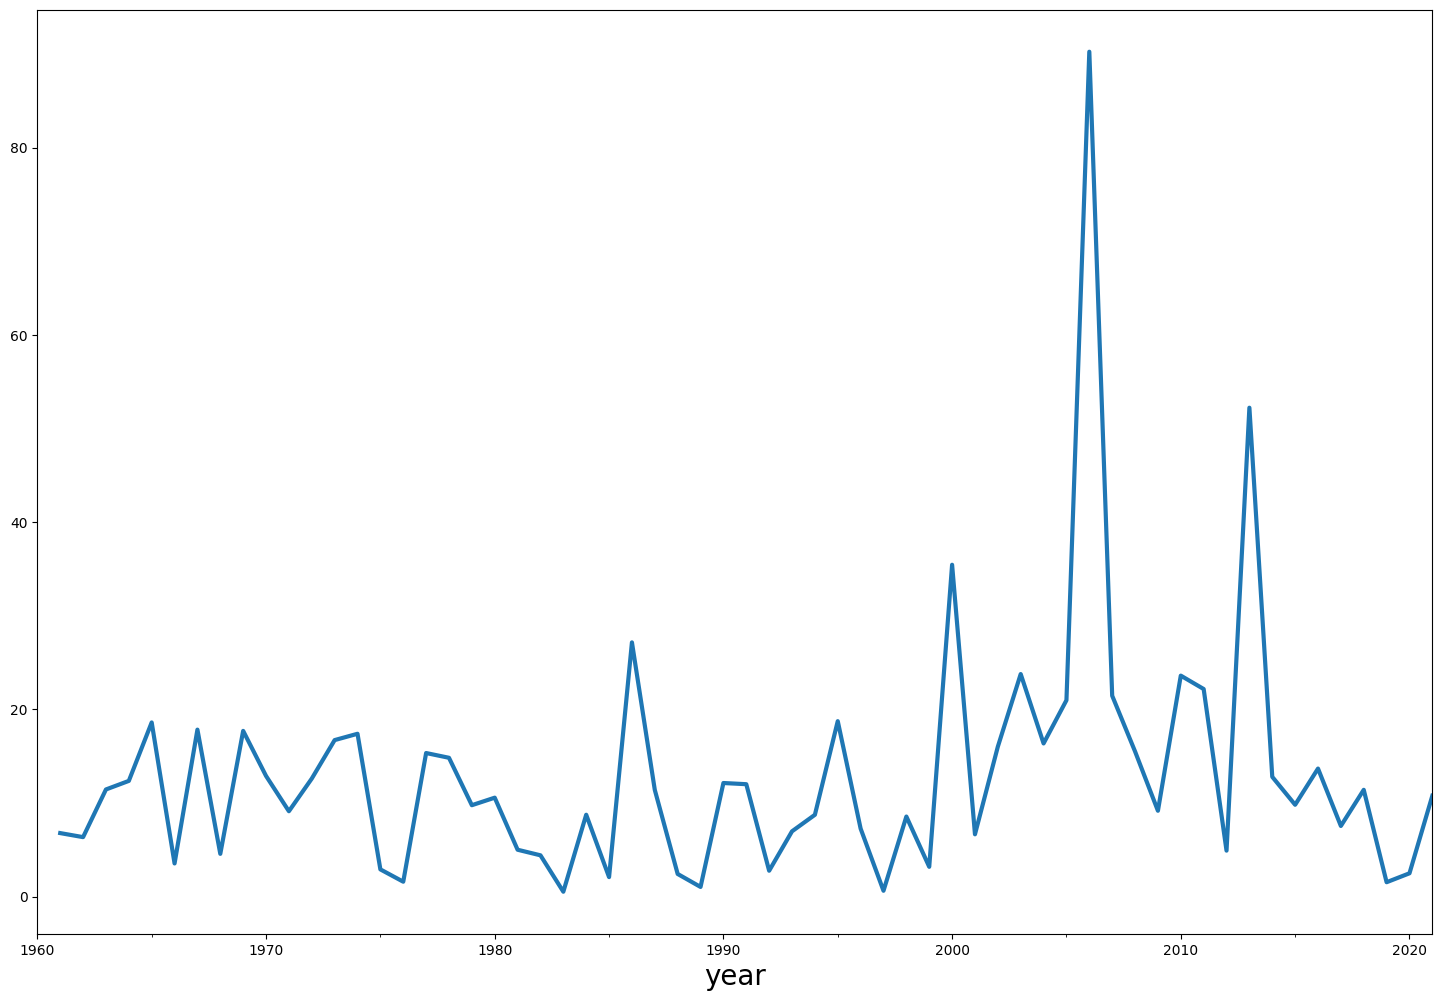

In [36]:
data["GDP_vol"].plot()
plt.show()

Видим, что дисперсия неоднородна. Необходимо обучить модель для предсказания ее колебаний

2. Разделим данные на тренировочную и тестовую выборки и построим график частичной корреляции

In [37]:
train_df = data.loc[:"2018-01-01"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 2), (3, 2))

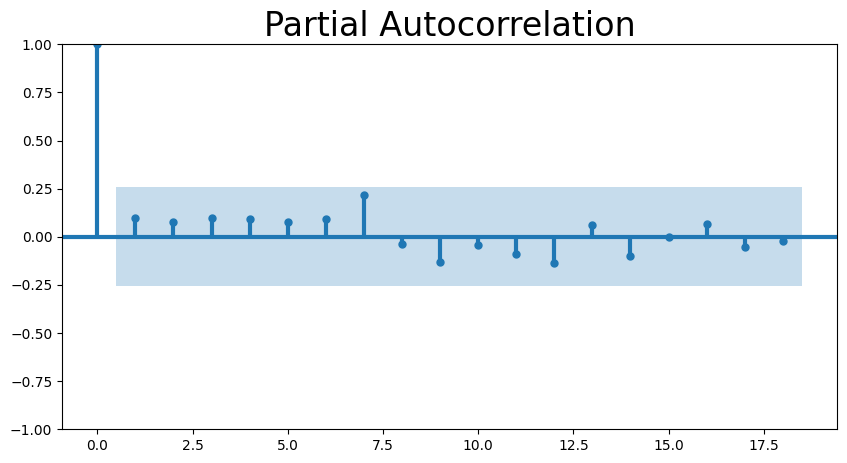

In [38]:
plt.rcParams["figure.figsize"] = 10, 5

sgt.plot_pacf(train_df['GDP_vol'][1:], method="ywm")
plt.show()

Мы видим, что все лаги несильно отличаются от нуля, но самый большой из них 7 лаг

In [39]:
adfuller(train_df['GDP_vol'][1:])

(-6.725311059553779,
 3.4014596148856493e-09,
 0,
 57,
 {'1%': -3.5506699942762414,
  '5%': -2.913766394626147,
  '10%': -2.5946240473991997},
 382.739595975669)

Ряд стационарен, можно строить модель

3. Построим GARCH-модель

In [40]:
garch_df = pd.DataFrame(data["GDP_vol"].loc[data.index])
garch_df.loc[train_df.index, "GDP_vol"] = train_df["GDP_vol"].dropna()

In [41]:
model = arch_model(garch_df["GDP_vol"].dropna(), p=7, q=7)
model_results = model.fit(last_obs=test_df.index[0], update_freq=5)

Iteration:      5,   Func. Count:     91,   Neg. LLF: 234.38048115955718
Iteration:     10,   Func. Count:    179,   Neg. LLF: 214.61759052175603
Iteration:     15,   Func. Count:    265,   Neg. LLF: 214.40871495512866
Iteration:     20,   Func. Count:    350,   Neg. LLF: 214.10079395318482
Iteration:     25,   Func. Count:    435,   Neg. LLF: 214.01143994526097
Optimization terminated successfully    (Exit mode 0)
            Current function value: 214.00780231871062
            Iterations: 29
            Function evaluations: 492
            Gradient evaluations: 28


In [42]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                GDP_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -214.008
Distribution:                  Normal   AIC:                           460.016
Method:            Maximum Likelihood   BIC:                           492.983
                                        No. Observations:                   58
Date:                Wed, Aug 16 2023   Df Residuals:                       57
Time:                        14:49:52   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.8666      1.572      7.550  4.349e-14 [  8.786, 14.947]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         44.1055     42.301      1.043      0.297    [-38.802,1.270e+02]
alpha[1]   3.2351e-08  7.767e-02  4.165e-07      1.000      [ -0.152,  0.152]
alpha[2]   7.8463e-08  2.299e-02  3.412e-06      1.000 [-4.507e-02,4.507e-02]
alpha[3]   6.5621e-14  6.853e-02  9.576e-13      1.000      [ -0.134,  0.134]
alpha[4]   3.6162e-03  1.492e-02      0.242      0.809 [-2.563e-02,3.286e-02]
alpha[5]   6.2496e-14  1.274e-02  4.906e-12      1.000 [-2.497e-02,2.497e-02]
alpha[6]       0.7319      0.915      0.800      0.424      [ -1.062,  2.525]
alpha[7]       0.1024      0.643      0.159      0.873      [ -1.157,  1.362]
beta[1]    5.7084e-07      0.501  1.139e-06      1.000      [ -0.982,  0.982]
beta[2]    3.6496e-07  6.190e-02  5.896e-06      1.000      [ -0.121,  0.121]
beta[3]    3.4349e-07  2.869e-02  1.197e-05      1.000 [-5.624e-02,5.624e-02]
beta[4]    3.0295e-07  9.122e-02  3.321e-06      1.000      [ -0.179,  0.179]
beta[5]    1.7888e-05  5.268e-02  3.396e-04      1.000      [ -0.103,  0.103]
beta[6]    3.6179e-07  3.014e-02  1.200e-05      1.000 [-5.908e-02,5.908e-02]
beta[7]    2.9083e-07      1.155  2.517e-07      1.000      [ -2.265,  2.265]
=============================================================================

Covariance estimator: robust
"""

4. Делаем предсказание и визуализируем результат

In [43]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
    test_df.index
]

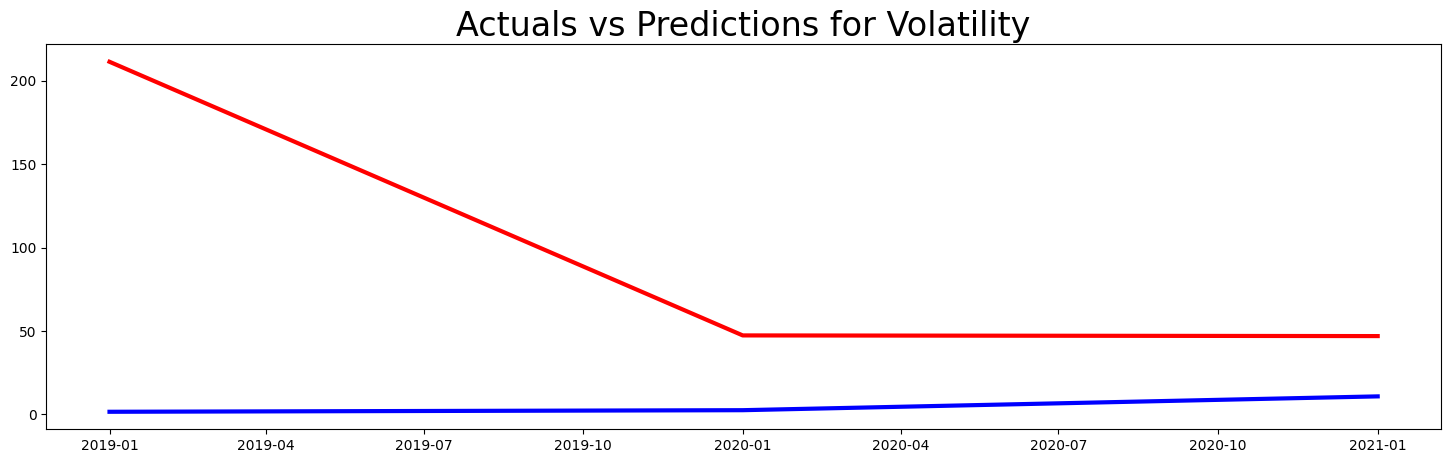

In [47]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(test_df['GDP_vol'], color='blue')
plt.plot(predictions_df["Predictions"], color='red')

plt.title("Actuals vs Predictions for Volatility", size=24)

plt.show()

Очевидно, модель не вполне уловила зависимость по причине недостаточного количества данных

5. Построим модель линейной регрессии

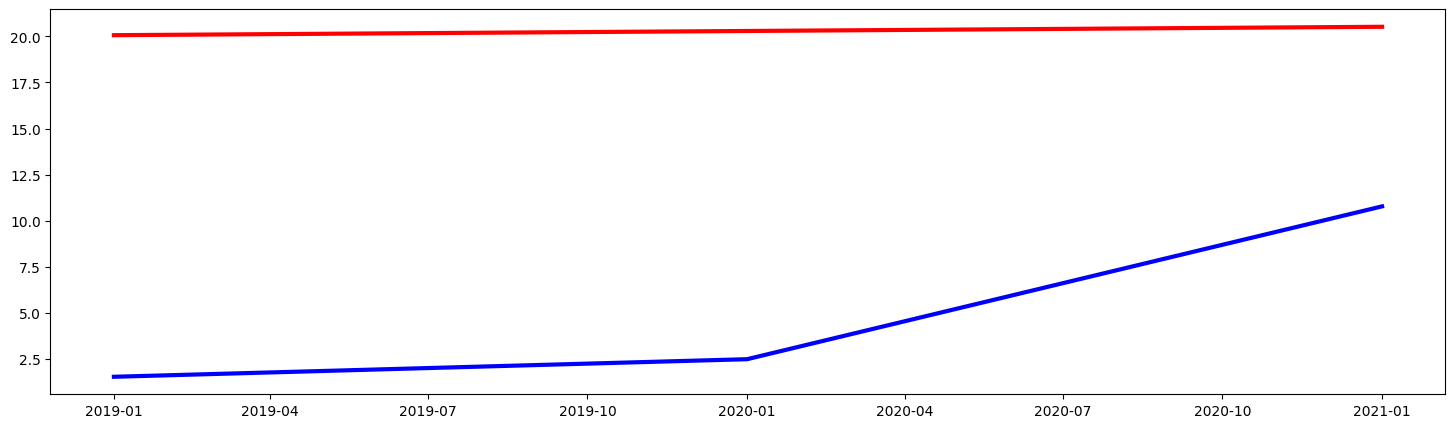

In [45]:
from sklearn.linear_model import LinearRegression

X_train = pd.DataFrame(range(data["GDP_vol"].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(data["GDP_vol"].shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df["GDP_vol"].fillna(0)
y_test = test_df["GDP_vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test, color='blue')
plt.plot(pd.Series(lr_predict, index=y_test.index), color='red')
plt.show()

Модель линейной регрессии не справилась с задачей прогнозирования волатильности